In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
%config InlineBackend.figure_format = "svg"

In [2]:
def createPreferenceGraph(n, maxPreferencesPerCategory) :
    strings = ["prefers to collaborate with", # question item = 0
               "prefers to socialize with", # question item = 1
               "perceives that the node ? prefers to collaborate with him", # question item = 2
               "perceives that the node ? prefers to socialize with him", # question item = 3
               "avoids collaborating with", # question item = 4
               "avoids socializing with", # question item = 5
               "perceives that the node ? avoids collaborating with him", # question item = 6
               "perceives that the node ? avoids socializing with him"] # question item = 7
    
    def editString(s, node1, node2) :
        if "?" in s :
            return f"node {node1} {str(node2).join(s.split('?'))}"
        else :
            return f"node {node1} {s} node {node2}"

    G = nx.MultiDiGraph()
    G.add_nodes_from(range(n))

    for node in G.nodes() :
        # neglect current node
        nodes = list(filter(lambda item : item != node, G.nodes()))

        # find number of answers for the 8 question items
        numberOfChoices = np.random.choice(range(1, maxPreferencesPerCategory + 1), size=8)
        
        # find answers (nodes-peers) for question items 0, 1, 2, 3
        peersA, peersB, peersC, peersD = np.random.choice(nodes, size=numberOfChoices[0], replace=False), \
            np.random.choice(nodes, size=numberOfChoices[1], replace=False), \
                np.random.choice(nodes, size=numberOfChoices[2], replace=False), \
                    np.random.choice(nodes, size=numberOfChoices[3], replace=False) 
         
        # find answers (nodes-peers) for question items 4, 5, 6, 7
        # !! neglect nodes already chosen in question items 0, 1, 2, 3 respectively (preference vs avoidance for item) !!
        peersE, peersF, peersG, peersH = np.random.choice(list(set(nodes)-set(peersA)), size=numberOfChoices[4], replace=False), \
            np.random.choice(list(set(nodes)-set(peersB)), size=numberOfChoices[5], replace=False), \
                np.random.choice(list(set(nodes)-set(peersC)), size=numberOfChoices[6], replace=False), \
                    np.random.choice(list(set(nodes)-set(peersD)), size=numberOfChoices[7], replace=False)

        # add edges in preferenceGraph with an opinion string and question item index
        weightIndex = 0
        for peers in [peersA, peersB, peersC, peersD, peersE, peersF, peersG, peersH] :
            for peer in peers :
                G.add_edge(int(node), int(peer), opinion=editString(strings[weightIndex], node, peer), questionItem=weightIndex)
            weightIndex += 1

    return G

In [3]:
options = {
    "n" : 100, # number of students
    "maxPreferencesPerCategory" : 50 # max number of student's preferences for a quiz question
}

G = createPreferenceGraph(**options)
print(f"number of nodes: {G.number_of_nodes()}")
print(f"number of edges: {G.number_of_edges()}")

# plt.figure(figsize=(12,12))
# plt.axis('equal')
# options = {
#             "node_color": "white",
#             "edgecolors": "#b94042",
#             "linewidths": 1,
#             "node_size": 200,
#             "edge_color": "#3a3b95",
#             "font_size": 10,
#             "font_color": "#b94042"
#             }
# nx.draw_circular(G, with_labels=True, **options)

number of nodes: 100
number of edges: 20132


In [4]:
for u, v, data in G.edges(data=True):
    print(f"{data['opinion']} => question item = {data['questionItem']}")

node 0 prefers to collaborate with node 95 => question item = 0
node 0 perceives that the node 95 prefers to socialize with him => question item = 3
node 0 prefers to collaborate with node 46 => question item = 0
node 0 prefers to socialize with node 46 => question item = 1
node 0 perceives that the node 46 prefers to socialize with him => question item = 3
node 0 prefers to collaborate with node 87 => question item = 0
node 0 avoids socializing with node 87 => question item = 5
node 0 perceives that the node 87 avoids collaborating with him => question item = 6
node 0 prefers to collaborate with node 80 => question item = 0
node 0 prefers to socialize with node 80 => question item = 1
node 0 prefers to collaborate with node 2 => question item = 0
node 0 prefers to socialize with node 2 => question item = 1
node 0 perceives that the node 2 prefers to socialize with him => question item = 3
node 0 perceives that the node 2 avoids collaborating with him => question item = 6
node 0 prefer

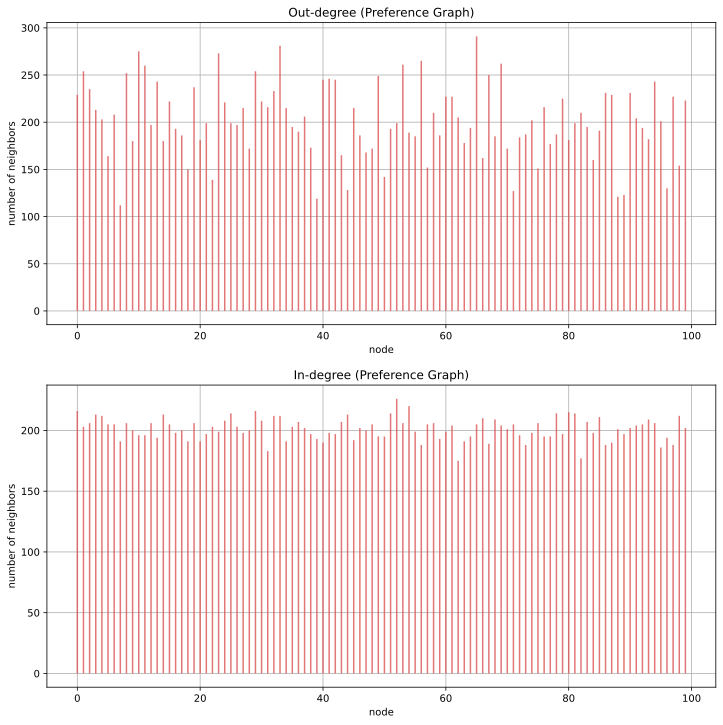

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
degrees = [dict(G.out_degree()), dict(G.in_degree())]

for i in range(2) :
    ax[i].vlines(x=list(degrees[i].keys()), ymin=0, ymax=list(degrees[i].values()), color="#DB5454", alpha=0.8)
    ax[i].grid(True)
    ax[i].set_title(f"{['Out-degree', 'In-degree'][i]} (Preference Graph)")
    ax[i].set_xlabel("node")
    ax[i].set_ylabel("number of neighbors")

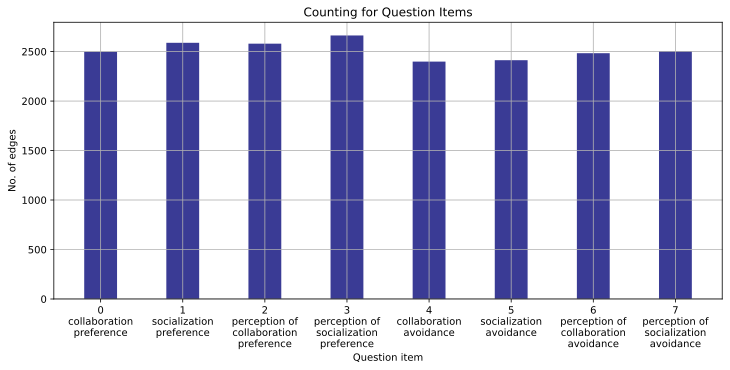

In [6]:
questionItemsCounting = [0]*8
for u, v, data in G.edges(data=True) :
    questionItemsCounting[data["questionItem"]] += 1

fig = plt.figure(figsize = (12, 5))
plt.bar(["0\ncollaboration\npreference",
        "1\nsocialization\npreference",
        "2\nperception of\ncollaboration\npreference",
        "3\nperception of\nsocialization\npreference",
        "4\ncollaboration\navoidance",
        "5\nsocialization\navoidance",
        "6\nperception of\ncollaboration\navoidance",
        "7\nperception of\nsocialization\navoidance"], questionItemsCounting, color ="#3a3b95", width = 0.4)
plt.grid(True)
plt.xlabel("Question item")
plt.ylabel("No. of edges")
plt.title("Counting for Question Items")
plt.show()

In [7]:
def saveGraphJson(G, path) :
    def convertToJSON(G) :
        nodes = [{"id": node} for node in G.nodes()]
        
        edges = [{
            "source": i,
            "target": j,
            "opinion": data["opinion"],
            "question item": data['questionItem']
        } for i, j, data in G.edges(data=True)]

        return {
            "nodes": nodes,
            "edges": edges
        }
    with open(path, "w") as write_file:
        json.dump(convertToJSON(G), write_file)


Counter({0.5: 299, 0.575: 168, 0.675: 160, 0.425: 154, 0.75: 127, 0.85: 123, 0.65: 121, 0.4: 119, 0.35: 117, 0.25: 116, 0.6: 113, 0.7: 109, 0.3: 104, 0.15: 98, 0.475: 97, 0.325: 80, 1.0: 80, 0.175: 74, 0.0: 69, 0.6666666666666666: 66, 0.22499999999999998: 65, 0.5666666666666667: 62, 0.825: 62, 0.6333333333333333: 61, 0.32499999999999996: 58, 0.3333333333333333: 57, 0.5249999999999999: 56, 0.3833333333333333: 55, 0.4833333333333333: 52, 0.39999999999999997: 52, 0.925: 51, 0.7749999999999999: 51, 0.43333333333333335: 48, 0.55: 48, 0.5833333333333333: 47, 0.41666666666666663: 47, 0.6166666666666667: 46, 0.5333333333333333: 46, 0.525: 43, 0.44999999999999996: 42, 0.5166666666666666: 41, 0.7333333333333333: 41, 0.4583333333333333: 39, 0.5916666666666667: 38, 0.075: 38, 0.3416666666666667: 36, 0.16666666666666666: 36, 0.6833333333333333: 33, 0.4666666666666666: 33, 0.6583333333333333: 32, 0.375: 32, 0.8: 32, 0.4083333333333333: 31, 0.5083333333333333: 31, 0.625: 30, 0.26666666666666666: 29, 

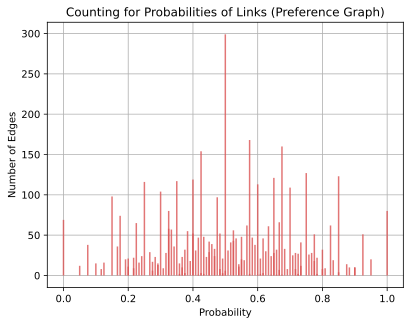

In [8]:
def calculateProbability(item) :
    if item == 0 or item == 1 :
        return 1
    elif item == 2 or item == 3 :
        return 0.7
    elif item == 4 or item == 5 :
        return 0
    else :
        return 0.3
        
#dictionary {edge : probability of existing in the Preference Graph}
edgesProbabilities = {}
def findProbBetween(node1, node2) :
	edges_node1_to_node2 = [calculateProbability(data["questionItem"]) for u, v, data in G.edges(node1, data=True) if v == node2]
	edges_node2_to_node1 = [calculateProbability(data["questionItem"]) for u, v, data in G.edges(node2, data=True) if v == node1]

	if len(edges_node1_to_node2) == 0 and len(edges_node2_to_node1) == 0 :
		return None
	elif len(edges_node1_to_node2) == 0 :
		return np.average(edges_node2_to_node1)
	elif len(edges_node2_to_node1) == 0 :
		return np.average(edges_node1_to_node2)
	else :
		return np.average([np.average(edges_node1_to_node2), np.average(edges_node2_to_node1)])


n = G.number_of_nodes()
for node in range(n) :
    for other in range(node + 1, n) :
        prob = findProbBetween(node, other)
        if prob is not None :
            edgesProbabilities[(node, other)] = prob

fig, ax = plt.subplots()
count = Counter(edgesProbabilities.values())
print(count)
ax.vlines(x=list(count.keys()), ymin=0, ymax=list(count.values()), color="#DB5454", alpha=0.8)
ax.grid(True)
ax.set_title(f"Counting for Probabilities of Links (Preference Graph)")
ax.set_xlabel("Probability")
ax.set_ylabel("Number of Edges")
plt.show()

In [9]:
saveGraphJson(G, "./preferenceGraph.json")